<a href="https://colab.research.google.com/github/shikha-aggarwal/nlp/blob/master/TwitterSentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import nltk
from nltk.corpus import twitter_samples
import matplotlib.pyplot as plt

In [3]:
nltk.download('twitter_samples')

[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Unzipping corpora/twitter_samples.zip.


True

In [4]:
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')

In [5]:
print(len(all_positive_tweets), len(all_negative_tweets))

5000 5000


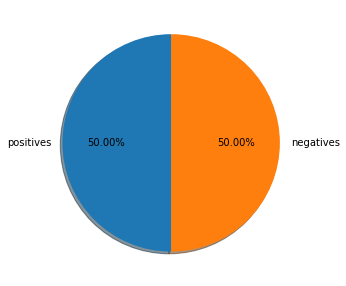

In [6]:
fig = plt.figure(figsize = (5, 5))

labels = ['positives', 'negatives']

data = [len(all_positive_tweets), len(all_negative_tweets)]

plt.pie(data, labels = labels, autopct='%.2f%%', startangle=90, shadow=True)

plt.show()

In [7]:
import random

print(all_positive_tweets[random.randint(0, len(all_positive_tweets))])

print("----")

print(all_negative_tweets[random.randint(0, len(all_positive_tweets))])

@mikestone14  Your tweet is very much appreciated! Thank you for being such a dedicated member :)
----
Party promotions are over :(


**Preprocessing**

In [8]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [9]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer

import string
import re

from collections import defaultdict
import numpy as np

In [10]:

def preprocess(tweet):
  # remove hashtags
  tweet_edited = re.sub(r'#', '', tweet)

  # remove urls
  tweet_edited = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet_edited)

  # remove old style retweet text "RT"
  tweet_edited = re.sub(r'^RT[\s]+', '', tweet_edited)

  tweet_tokenized = []
  stopword_list = stopwords.words('english')
  tokenizer = TweetTokenizer(preserve_case=False, reduce_len=True, 
                             strip_handles=True)
  stemmer = PorterStemmer()

  for word in tokenizer.tokenize(tweet_edited):
    if word not in stopword_list and word not in string.punctuation:
      tweet_tokenized.append(stemmer.stem(word))

  return tweet_tokenized

In [11]:
positive_tweets_tokenized = []
negative_tweets_tokenized = []
for tweet in all_positive_tweets:
  positive_tweets_tokenized.append(preprocess(tweet))

for tweet in all_negative_tweets:
  negative_tweets_tokenized.append(preprocess(tweet))


In [12]:
print(all_positive_tweets[2277])
print(positive_tweets_tokenized[2277])

My beautiful sunflowers on a sunny Friday morning off :) #sunflowers #favourites #happy #Friday off… https://t.co/3tfYom0N1i
['beauti', 'sunflow', 'sunni', 'friday', 'morn', ':)', 'sunflow', 'favourit', 'happi', 'friday', '…']


In [13]:
print(all_negative_tweets[2277])
print(negative_tweets_tokenized[2277])

okay she doesnt want to talk to me then I will stop :(
['okay', 'doesnt', 'want', 'talk', 'stop', ':(']


In [14]:
frequency_map = defaultdict(lambda : 0)

for tweet in positive_tweets_tokenized:
  for word in tweet:
    frequency_map[(word, 1)] += 1

for tweet in negative_tweets_tokenized:
  for word in tweet:
    frequency_map[(word, 0)] += 1

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128556 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 128556 missing from current font.
  font.set_text(s, 0, flags=flags)


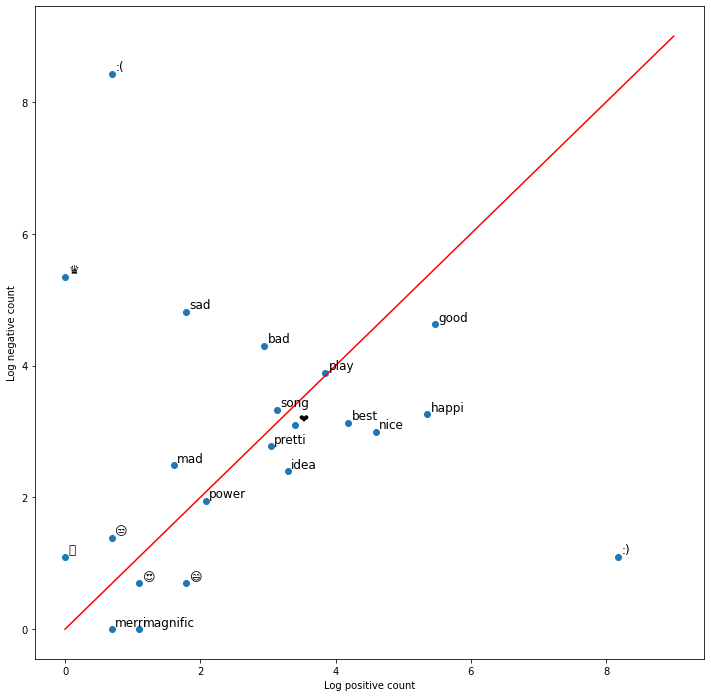

In [20]:
sample_keys = ['happi', 'merri', 'nice', 'good', 'bad', 'sad', 'mad', 'best', 'pretti',
        '❤', ':)', ':(', '😒', '😬', '😄', '😍', '♛',
        'song', 'idea', 'power', 'play', 'magnific']

data = []
for key in sample_keys:
  data.append((key, frequency_map[(key, 1)], frequency_map[(key, 0)]))

fig, ax = plt.subplots(figsize = (12, 12))

x = np.log([x[1] + 1 for x in data]) # positives
y = np.log([x[2] + 1 for x in data]) # negative count

ax.scatter(x, y)

plt.xlabel("Log positive count")
plt.ylabel("Log negative count")

for i in range(len(data)):
  ax.annotate(data[i][0], (x[i]+0.05, y[i]+0.05), fontsize=12)

ax.plot([0, 9], [0, 9], color='red')
plt.show()

**Create Tweet feature vectors**

In [32]:
def get_feature_vector(tokenized_tweet):
  pos_count, neg_count = 0, 0
  for word in tokenized_tweet:
    pos_count += frequency_map[(word, 1)]
    neg_count += frequency_map[(word, 0)]
  return [1, pos_count, neg_count]

In [33]:
print(all_positive_tweets[2277])
print(get_feature_vector(positive_tweets_tokenized[2277]))

for word in positive_tweets_tokenized[2277]:
  print(frequency_map[(word, 1)], frequency_map[(word, 0)])

My beautiful sunflowers on a sunny Friday morning off :) #sunflowers #favourites #happy #Friday off… https://t.co/3tfYom0N1i
[1, 4223, 119]
50 11
2 0
6 1
116 12
101 31
3568 2
2 0
13 9
211 25
116 12
38 16


**Partition data into test and train**

In [54]:
train_X_list = []

for tokenized_tweet in positive_tweets_tokenized[:4000]:
  train_X_list.append(get_feature_vector(tokenized_tweet))

for tokenized_tweet in negative_tweets_tokenized[:4000]:
  train_X_list.append(get_feature_vector(tokenized_tweet))

train_X = np.array(train_X_list, dtype='float64')
train_Y = np.append(np.ones((4000, )), np.zeros((4000, )), axis = 0)


In [55]:
print(train_X.shape, train_Y.shape)

(8000, 3) (8000,)


**TRAIN**

In [56]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state = 0).fit(train_X, train_Y)

In [59]:
test_X_list = []

for tokenized_tweet in positive_tweets_tokenized[-1000:]:
  test_X_list.append(get_feature_vector(tokenized_tweet))

for tokenized_tweet in negative_tweets_tokenized[-1000:]:
  test_X_list.append(get_feature_vector(tokenized_tweet))

test_X = np.array(test_X_list, dtype='float64')
test_Y = np.append(np.ones((1000, )), np.zeros((1000, )), axis = 0)

test_data = list(zip(test_X, test_Y))
random.shuffle(test_data)
test_X, test_Y = zip(*test_data)

In [65]:
clf.score(test_X, test_Y)

0.992

In [67]:
clf.coef_

array([[ 0.48571869,  0.00701322, -0.0080829 ]])

In [77]:
theta = clf.coef_.squeeze().tolist()
print(theta)

[0.48571869476652807, 0.007013220421437843, -0.008082900722350617]


In [74]:
def neg(theta, pos):
    return (-theta[0] - pos * theta[1]) / theta[2]

def direction(theta, pos):
    return    pos * theta[2] / theta[1]

In [75]:
theta = [7e-08, 0.0005239, -0.00055517]

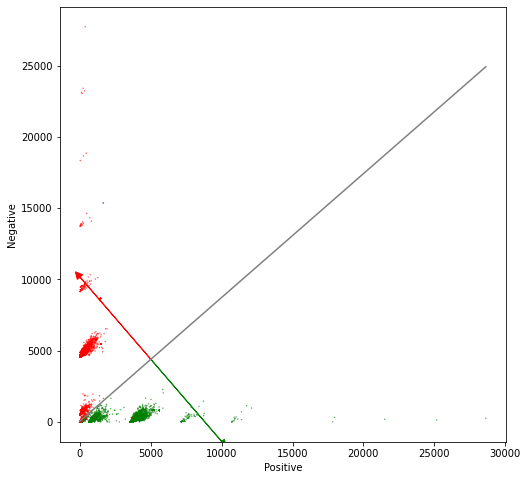

In [78]:
# Plot the samples using columns 1 and 2 of the matrix
fig, ax = plt.subplots(figsize = (8, 8))

colors = ['red', 'green']

# Color base on the sentiment Y
ax.scatter(train_X[:,1], train_X[:,2], c=[colors[int(k)] for k in train_Y], s = 0.1)  # Plot a dot for each pair of words
plt.xlabel("Positive")
plt.ylabel("Negative")

# Now lets represent the logistic regression model in this chart. 
maxpos = np.max(train_X[:,1])

offset = 5000 # The pos value for the direction vectors origin

# Plot a gray line that divides the 2 areas.
ax.plot([0,  maxpos], [neg(theta, 0),   neg(theta, maxpos)], color = 'gray') 

# Plot a green line pointing to the positive direction
ax.arrow(offset, neg(theta, offset), offset, direction(theta, offset), head_width=500, head_length=500, fc='g', ec='g')
# Plot a red line pointing to the negative direction
ax.arrow(offset, neg(theta, offset), -offset, -direction(theta, offset), head_width=500, head_length=500, fc='r', ec='r')

plt.show()